# Head Estimation Model

## 1. Load and Process Keypoints JSON

In [2]:
import json

# Load person_keypoints_train2017.json and extract poses which have all of their body keypoints
'''
"keypoints": [
                        "nose",
                        "left_eye",
                        "right_eye",
                        "left_ear",
                        "right_ear",
                        "left_shoulder",
                        "right_shoulder",
                        "left_elbow",
                        "right_elbow",
                        "left_wrist",
                        "right_wrist",
                        "left_hip",
                        "right_hip",
                        "left_knee",
                        "right_knee",
                        "left_ankle",
                        "right_ankle"
                    ],
'''

def extract_poses(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

    poses_list = []

    for annotation in data['annotations']:
        visibility = annotation['keypoints'][2::3]

        if 0 not in visibility[5:]:
            keypoint_x = annotation['keypoints'][0::3]
            keypoint_y = annotation['keypoints'][1::3]

            max_x = max(keypoint_x)
            min_x = min(keypoint_x)
            max_y = max(keypoint_y)
            min_y = min(keypoint_y)

            height = max_y - min_y
            width = max_x - min_x

            if height > width:
                keypoint_x = [(x - min_x) / height for x in keypoint_x]
                keypoint_y = [(y - min_y) / height for y in keypoint_y]
            else:
                keypoint_x = [(x - min_x) / width for x in keypoint_x]
                keypoint_y = [(y - min_y) / width for y in keypoint_y]

            poses_list.append((keypoint_x[5:] + keypoint_y[5:], 
                                   keypoint_x[:5] + keypoint_y[:5]))

    return poses_list

# File path to the JSON file
file_path = 'person_keypoints_train2017.json'

# Extract keypoints
extracted_poses = extract_poses(file_path)

# Print the result
result_len = len(extracted_poses)
print(extracted_poses[:5])
print(f"Number of extracted poses: {result_len}")

# Save the result
with open("train.json", "w") as train:
    json.dump(extracted_poses[:int(result_len * 0.8)], train)

with open("test.json", "w") as test:
    json.dump(extracted_poses[int(result_len * 0.8):], test)

[([0.9944954128440368, 0.9706422018348624, 1.0, 0.9669724770642202, 1.0, 0.9688073394495413, 0.9944954128440368, 0.9779816513761468, 0.9926605504587156, 0.9926605504587156, 0.9651376146788991, 0.9908256880733946, 0.3779816513761468, 0.3779816513761468, 0.4, 0.4036697247706422, 0.42201834862385323, 0.43119266055045874, 0.42385321100917434, 0.42568807339449544, 0.45504587155963305, 0.46055045871559636, 0.47522935779816516, 0.4917431192660551], [0.9889908256880734, 0.9944954128440368, 0.9871559633027523, 0.0, 0.9798165137614679, 0.3577981651376147, 0.3559633027522936, 0.3541284403669725, 0.0, 0.3577981651376147]), ([0.4715447154471545, 0.4959349593495935, 0.42276422764227645, 0.4349593495934959, 0.36585365853658536, 0.3821138211382114, 0.4796747967479675, 0.516260162601626, 0.3983739837398374, 0.5040650406504065, 0.4146341463414634, 0.5040650406504065, 0.6910569105691057, 0.6910569105691057, 0.7154471544715447, 0.7642276422764228, 0.7357723577235772, 0.7926829268292683, 0.8170731707317073

## 2. Load Libraries

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset

print(f"MPS Support: {torch.backends.mps.is_built()}")
print(f"MPS Availability: {torch.backends.mps.is_available()}")

Matplotlib is building the font cache; this may take a moment.


MPS Support: True
MPS Availability: True


In [18]:
device = None

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f'Device: {device}')

Device: mps


## 3. Model and Dataloader Definition

In [32]:
class TrainDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        train_path = data_dir + "/train.json"

        with open(train_path, 'r') as f:
            data = json.load(f)
            data_len = len(data)
            self.data = data[:int(data_len * 0.9)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data[index][0]), torch.tensor(self.data[index][1])


class ValDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        train_path = data_dir + "/train.json"

        with open(train_path, 'r') as f:
            data = json.load(f)
            data_len = len(data)
            self.data = data[int(data_len * 0.9):]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data[index][0]), torch.tensor(self.data[index][1])
    
    
class TestDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        test_path = data_dir + "/test.json"

        with open(test_path, 'r') as f:
            self.data = json.load(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data[index][0]), torch.tensor(self.data[index][1])

In [41]:
# Define the model
class HeadEstimator(nn.Module):
    def __init__(self):
        super(HeadEstimator, self).__init__()
        self.fc1 = nn.Linear(24, 64)  # 12 MPII/COCO keypoints * 2 (x, y)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 10)  # 5 COCO head keypoints * 2 (x, y)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [42]:
train_dataset = TrainDataset(data_dir='.')
val_dataset = ValDataset(data_dir='.')
test_dataset = TestDataset(data_dir='.')

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

28839
3205
8011


In [43]:
def train_model(trainloader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for batch, (inputs, targets) in tqdm(enumerate(trainloader), total = len(trainloader)):

        inputs = inputs.to(device)
        targets = targets.to(device)
        criterion = criterion.to(device)

        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, targets)

        loss.backward()
        optimizer.step()
        
        total_loss += loss.cpu().item()

    return total_loss/(batch+1)

In [44]:
def val_model(valloader, model, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch, (inputs, targets) in tqdm(enumerate(valloader), total = len(valloader)):

            inputs = inputs.to(device)
            targets = targets.to(device)
            criterion = criterion.to(device)

            preds = model(inputs)
            loss = criterion(preds, targets)
            
            total_loss += loss.cpu().item()

    return total_loss/(batch+1)

## 4. Training Model

In [45]:
batch_size = 256
learning_rate = 1e-4
epochs = 10

trainLoader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valLoader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

model = HeadEstimator()
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = {'train_loss':[], 'val_loss':[]}

print(model)

HeadEstimator(
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [46]:
print("Training...")

for epoch in range(epochs):
    train_loss = train_model(trainLoader, model, criterion, optimizer, device)
    val_loss = val_model(valLoader, model, criterion, device)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    if epoch % 2 == 0:
        print("Saving checkpoint...")
        torch.save(model.state_dict(), f'./model.pth')

print('Finished Training')

Training...


100%|██████████| 13/13 [00:00<00:00, 97.92it/s]


Epoch 1/10, Train Loss: 0.1402, Val Loss: 0.0938
Saving checkpoint...


100%|██████████| 13/13 [00:00<00:00, 180.33it/s]


Epoch 2/10, Train Loss: 0.0801, Val Loss: 0.0822


100%|██████████| 13/13 [00:00<00:00, 180.73it/s]


Epoch 3/10, Train Loss: 0.0731, Val Loss: 0.0780
Saving checkpoint...


100%|██████████| 13/13 [00:00<00:00, 179.56it/s]


Epoch 4/10, Train Loss: 0.0704, Val Loss: 0.0763


100%|██████████| 13/13 [00:00<00:00, 169.57it/s]


Epoch 5/10, Train Loss: 0.0689, Val Loss: 0.0751
Saving checkpoint...


100%|██████████| 13/13 [00:00<00:00, 176.59it/s]


Epoch 6/10, Train Loss: 0.0678, Val Loss: 0.0743


100%|██████████| 13/13 [00:00<00:00, 166.71it/s]


Epoch 7/10, Train Loss: 0.0669, Val Loss: 0.0732
Saving checkpoint...


100%|██████████| 13/13 [00:00<00:00, 180.42it/s]


Epoch 8/10, Train Loss: 0.0661, Val Loss: 0.0727


100%|██████████| 13/13 [00:00<00:00, 180.61it/s]


Epoch 9/10, Train Loss: 0.0652, Val Loss: 0.0716
Saving checkpoint...


100%|██████████| 13/13 [00:00<00:00, 173.65it/s]

Epoch 10/10, Train Loss: 0.0641, Val Loss: 0.0705
Finished Training


<function matplotlib.pyplot.show(close=None, block=None)>

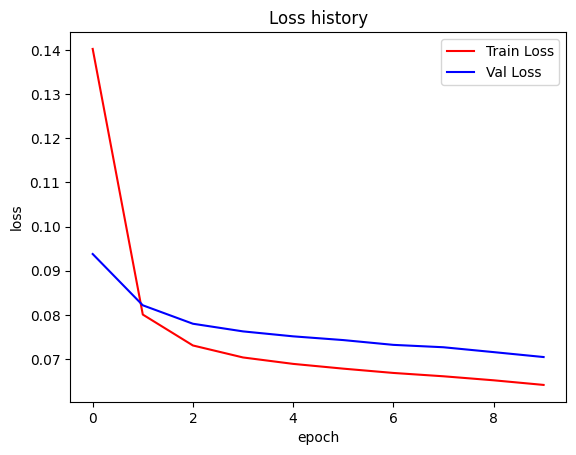

In [47]:
plt.plot(range(epochs), history['train_loss'], label='Train Loss', color='red')
plt.plot(range(epochs), history['val_loss'], label='Val Loss', color='blue')

plt.title('Loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show

## 5. Test Model

In [48]:
def test_model(testloader, model, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch, (inputs, targets) in tqdm(enumerate(testloader), total = len(testloader)):

            inputs = inputs.to(device)
            targets = targets.to(device)

            preds = model(inputs)
            loss = criterion(preds, targets)
            
            total_loss += loss.cpu().item()

    return total_loss/(batch+1)

In [49]:
testLoader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

print("Testing...")
test_loss = test_model(testLoader, model, criterion, device)

print(f"Test Loss: {test_loss:.4f}")

Testing...


100%|██████████| 32/32 [00:00<00:00, 46.37it/s] 

Test Loss: 0.0712


## 6. Inference

In [ ]:
def inference(model, input, device):
    model.eval()
    input = input.to(device)

    with torch.no_grad():
        pred = model(input)
        
    return pred